# **Trensfer learning with TensorFlow Part 2: Fine-tuning**

In [1]:
import functions
import importlib
importlib.reload(functions)

<module 'functions' from 'd:\\1. Projects\\5. TensorFlow and Deep Learning Fundamentals\\functions.py'>

In previous notebook, we covered transfer learning feature exteaction, now it's time to learn about a new kind of transfer learning: **fine-tuning**.

### **Let's get some data**

This time we're going to see how we can use pretrained models within `tf.keras.applications` and apply them to our own data (recognizing images of food).

In [2]:
# Get 10% of training data of 10 classes of Food 101
from functions import unzip_data

unzip_data(filename='data/10_food_classes_10_percent.zip', 
           dest='data', 
           del_MACOSX_file=True)

In [3]:
# Check how many images and subdirectories are in our dataset
from functions import walk_through_dir

walk_through_dir('data/10_food_classes_10_percent')

There are 2 directories and 0 images in "data/10_food_classes_10_percent".
There are 10 directories and 0 images in "data/10_food_classes_10_percent\test".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\chicken_curry".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\chicken_wings".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\fried_rice".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\grilled_salmon".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\hamburger".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\ice_cream".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\pizza".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\ramen".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\steak".
There are 0 di

In [4]:
# Create training and test directory path
train_dir = 'data/10_food_classes_10_percent/train'
test_dir = 'data/10_food_classes_10_percent/test'

In [5]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

`tf.keras.preprocessing.image_dataset_from_directory()` is a new and better version of `tf.keras.preprocessing.image.ImageDataGenerator()`.

In [6]:
# Create batches of 32 images of size 224x224 split into red, green, blue colour channels from directory
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
# Check data data (BatchDataset type)
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# See and example of a batch data
for images, labels in train_data_10_percent.take(1):
    print(f'\nThere are {len(images)} images and {len(labels)} labels in a batch.\n')
    print('This is an exaple image:')
    print(images[0])
    print('\nAnd this is its label:')
    print(labels[0])


There are 32 images and 32 labels in a batch.

This is an exaple image:
tf.Tensor(
[[[ 8.          9.         13.        ]
  [ 8.          9.         13.        ]
  [ 8.          9.         13.        ]
  ...
  [ 4.          8.         11.        ]
  [ 3.2611609   7.261161   10.261161  ]
  [ 3.2611609   7.261161   10.261161  ]]

 [[ 8.          9.         13.        ]
  [ 8.          9.         13.        ]
  [ 8.          9.         13.        ]
  ...
  [ 4.783482    8.783482   11.783482  ]
  [ 5.566964    9.566964   12.566964  ]
  [ 6.350446   10.350447   13.350447  ]]

 [[ 8.          9.         13.        ]
  [ 8.          9.         13.        ]
  [ 8.          9.         13.        ]
  ...
  [ 8.546084    9.546084   12.934477  ]
  [10.611608   11.611608   15.        ]
  [11.611608   12.611608   16.        ]]

 ...

 [[ 6.          5.         11.        ]
  [ 6.          5.         11.        ]
  [ 5.          4.         10.        ]
  ...
  [82.42853    19.          1.7857361 ]


### **Modelling experiments we're going to run**

| **Experiment** | **Data** | **Preprocessing** | **Model**
| :------------: | :-------:  | :-------:  | :-------:  |
| **Model 0 (baseline)** | 10 classes of Food101 data (**random 10%** <br> training data only) | None | **Feature Extractor:** EfficientNetB0 <br> (pre-trained on ImageNet, all layers <br> frozen) with no top |
| **Model 1** | 10 classes of Food101 data (**random 1%** <br> training data only) | Random Flip, Rotation <br> Zoom, Height, Width <br> data augmentation | Same as model 0 |
| **Model 2** | Same as model 0 | Same as model 1 | Same as model 0 |
| **Model 3** | Same as model 0 | Same as model 1 | **Fine-tuning:** Model 2 (EfficientNetB0 <br> pre-trained on ImageNet) **with top <br> layer trained on custom data, top 10 <br> layers unfrozen** |
| **Model 4** | 10 classes of Food101 data (**100%** training <br> data only) | Same as model 1 | Same as model 3 |

## **Model 0: Building a transfer learning feature etraction model using the Keras Functional API**

The **sequentail API** is straight-forward, it runs our layers on sequential order.

The **functional API** however gives us more flexibility when building models.

In [10]:
#1. Create a base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False
)

# 2. Freeze the base model (so the pre-trained patterns are not updated during training)
base_model.trainable = False

# 3. Creat inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# 4. If you're using a model like ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNetB0 - it has recaling built in)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f'Shape after passing inputs through base model: {x.shape}')

# 6. Average pool the outputs (aggregare all the mose important information, reduce nummber of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'Shape after GlobalAveragePooling2D: {x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile a model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model and save its history
from functions import create_tensorboad_callback

history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25*len(test_data)),
                                 callbacks=[create_tensorboad_callback(dir_name='transfer_learning',
                                                                       experiment_name='10_percent_feature_estraction')])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoad log files to transfer_learning/10_percent_feature_estraction/2022-11-01_18-56-57
Epoch 1/5
24/24 [==============================] - 48s 2s/step - loss: 1.8872 - accuracy: 0.3960 - val_loss: 1.3104 - val_accuracy: 0.7336
Epoch 2/5
24/24 [==============================] - 43s 2s/step - loss: 1.0913 - accuracy: 0.7747 - val_loss: 0.8871 - val_accuracy: 0.8158
Epoch 3/5
24/24 [==============================] - 48s 2s/step - loss: 0.7812 - accuracy: 0.8373 - val_loss: 0.6843 - val_accuracy: 0.8536
Epoch 4/5
24/24 [==============================] - 46s 2s/step - loss: 0.6388 - accuracy: 0.8547 - val_loss: 0.6061 - val_accuracy: 0.8405
Epoch 5/5
24/24 [==============================] - 47s 2s/step - loss: 0.5307 - accuracy: 0.8853 - val_loss: 0.5416 - val_accuracy: 0.8618


In [11]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 95s 1s/step - loss: 0.5523 - accuracy: 0.8648


[0.5523282885551453, 0.864799976348877]

In [12]:
# Check the layers of the base model (EfficientNetB0)
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [13]:
# Check the summary of a base model (EfficientNetB0)
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [14]:
# How about a summary of a whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


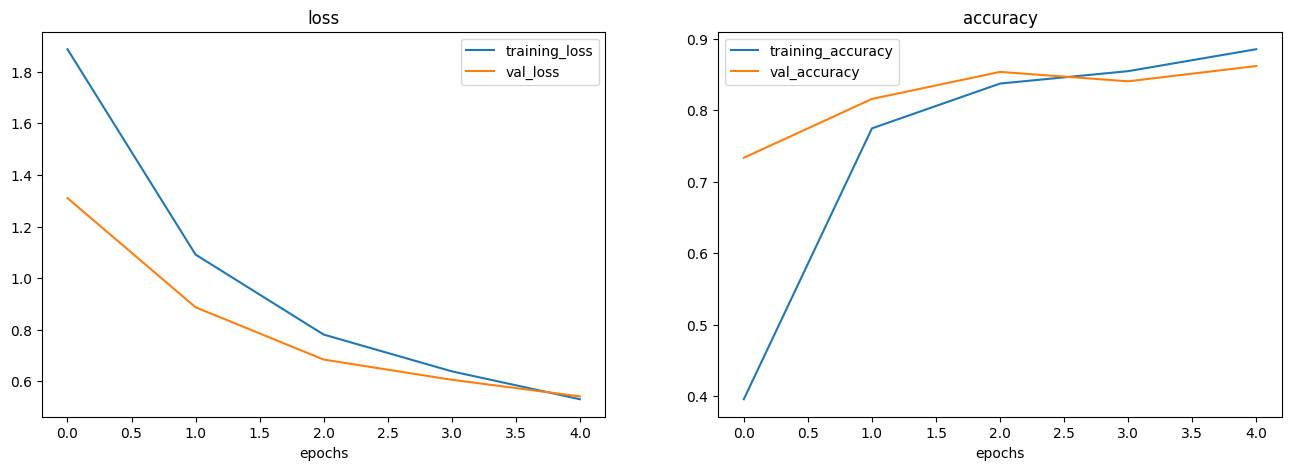

In [15]:
# Check learning curves
from functions import plot_loss_curves

plot_loss_curves(history_10_percent)

### **Getting a feature vector from a trained model**

Let's demonstrate the GlobalAveragePooling2D layer

We have a tensor after our model gose through `base model` of shape (None, 7, 7, 1280).

But then, when it passes through GlobalAveragePooling2D, it turns into (None, 1280),

Let's use a similar Shape tensor of (1, 4, 3, 3) and the pass it through it to GlobalAveragePooling2D.

In [16]:
# Define the input shape
input_shape = (1, 4, 3, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')

# Pass the random tensor through a GlobalAveragePooling2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D Global Averaged Pooled random tensor:\n {global_average_pooled_tensor}\n')

# Pass the random tensor through a GlobalMaxPooling2D layer
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f'2D Global Max Pooled random tensor:\n {global_max_pooled_tensor}\n')

# Check the shape of the different tensors
print(f'Shape of input tensor: {input_tensor.shape}')
print(f'Shape of Global Averaged Pooled 2D tensor: {global_average_pooled_tensor.shape}')
print(f'Shape of Global Max Pooled 2D tensor: {global_max_pooled_tensor.shape}')

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]]

  [[ 0.28893656 -1.5066116  -0.26454744]
   [-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]]

  [[ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]
   [ 0.77852213 -0.47338897  0.97772694]]

  [[ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]]]

2D Global Averaged Pooled random tensor:
 [[-0.01987256 -0.59964925 -0.29157034]]

2D Global Max Pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]

Shape of input tensor: (1, 4, 3, 3)
Shape of Global Averaged Pooled 2D tensor: (1, 3)
Shape of Global Max Pooled 2D tensor: (1, 3)


🔑 **Note:** One of the reasons why transfer learning is names how it is is because what often happens is pretrained model outputs a **feature vector** (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of `tf.keras.layers.GlobalAveragePooling2D()` layer) which can be then used to extract patterns out of for our own specific problem.

### **Running a series of transfer learning experiments**

We've seen the incredible results transfer learning can get with only 10% of the traning data, but how does it go with 1% of the training data.

1. `model_1` - **feature extraction** transfer learning with 1% of the traning data with data augmentation.
2. `model_2` - **feature extraction** transfer learning with 10% of the traning data with data augmentation.
3. `model_3` - **fine-tuning** transfer learning with 10% of the traning data with data augmentation.
4. `model_4` - **fine-tuning** transfer learning with 100% of the traning data with data augmentation.


🔑 **Note:** Throughout all experiments the same test dataset will be used to evaluate our model - this ensures cinsistency across evaluation metrics.

## **Getting and preprocessing data for model_1**

In [17]:
# Download and unzip data
from functions import unzip_data

unzip_data(filename='data/10_food_classes_1_percent.zip', dest='data')

In [18]:
# Create train and test dir
train_dir_1_percent = 'data/10_food_classes_1_percent/train'
test_dir = 'data/10_food_classes_10_percent/test'

In [19]:
# How many images are we working with
from functions import walk_through_dir

walk_through_dir('data/10_food_classes_1_percent')

There are 2 directories and 0 images in "data/10_food_classes_1_percent".
There are 10 directories and 0 images in "data/10_food_classes_1_percent\test".
There are 0 directories and 250 images in "data/10_food_classes_1_percent\test\chicken_curry".
There are 0 directories and 250 images in "data/10_food_classes_1_percent\test\chicken_wings".
There are 0 directories and 250 images in "data/10_food_classes_1_percent\test\fried_rice".
There are 0 directories and 250 images in "data/10_food_classes_1_percent\test\grilled_salmon".
There are 0 directories and 250 images in "data/10_food_classes_1_percent\test\hamburger".
There are 0 directories and 250 images in "data/10_food_classes_1_percent\test\ice_cream".
There are 0 directories and 250 images in "data/10_food_classes_1_percent\test\pizza".
There are 0 directories and 250 images in "data/10_food_classes_1_percent\test\ramen".
There are 0 directories and 250 images in "data/10_food_classes_1_percent\test\steak".
There are 0 directories a

In [20]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) # default = 32

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### **Adding data augmentation right into the model**

To add data augmentation right into the models, we can use the layers inside `tf.keras.layers.experimental.preprocessing()`.

The benefits of using data augmentation inside a model are:
* Preprocessing of images (augmenting them) happens on the GPU rather than CPU
* Image data augmentation only happens during training, so we can still export our model and use it elsewhere.

In [21]:
# Create daya augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    # tf.keras.layers.experimental.preprocessing.Rescaling(1./255) # for EfficientNet model it's not needed
], name='data_augmentation')

### **Visualize data augmentation layer (and see that happens to the data)**

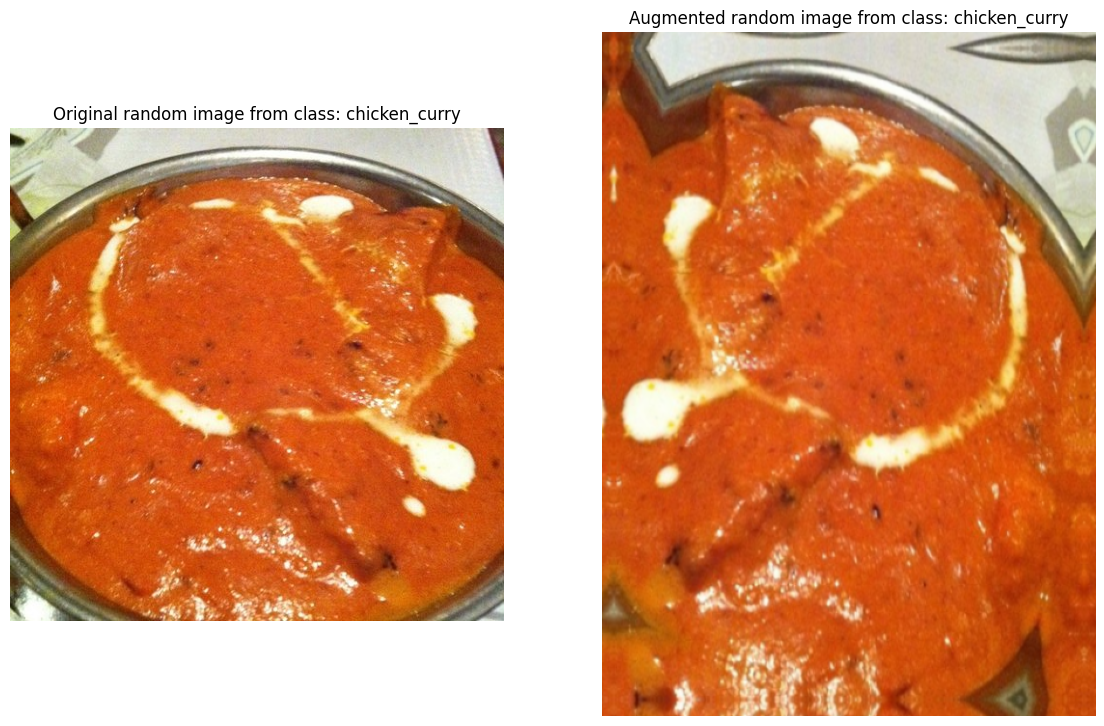

In [22]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = 'data/10_food_classes_10_percent/train/' + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

plt.figure(figsize=(14, 9))

# Read in the random image
img = mpimg.imread(random_image_path)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f'Original random image from class: {target_class}')
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(img, training=True)
plt.subplot(1, 2, 2)
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f'Augmented random image from class: {target_class}')
plt.axis(False);

### **Model 1: Feature extraction transfer learning on 1% of the data with data augmentation**

In [23]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)

base = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input layer
inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_mode the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Put a dense layer on as the output
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# Make a model using the inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

# Compile a modle
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
          
# Fit the model
history_model_1 = model_1.fit(train_data_1_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_1_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)),
                              # Track the model training loss
                              callbacks=[create_tensorboad_callback(dir_name='transfer_learning',
                                                                    experiment_name='1_percent_data_aug')])

Saving TensorBoad log files to transfer_learning/1_percent_data_aug/2022-11-01_19-02-32
Epoch 1/5
3/3 [==============================] - 39s 14s/step - loss: 2.4995 - accuracy: 0.0857 - val_loss: 2.2870 - val_accuracy: 0.1480
Epoch 2/5
3/3 [==============================] - 24s 11s/step - loss: 2.1983 - accuracy: 0.3000 - val_loss: 2.1360 - val_accuracy: 0.2664
Epoch 3/5
3/3 [==============================] - 27s 13s/step - loss: 1.9838 - accuracy: 0.3571 - val_loss: 2.0476 - val_accuracy: 0.3092
Epoch 4/5
3/3 [==============================] - 27s 12s/step - loss: 1.7731 - accuracy: 0.5000 - val_loss: 1.9362 - val_accuracy: 0.3964
Epoch 5/5
3/3 [==============================] - 24s 11s/step - loss: 1.6409 - accuracy: 0.6571 - val_loss: 1.8443 - val_accuracy: 0.4424


There is a bug in keras/tensorflow 2.9 and 2.10, which causes preprocess layers like rescaling to be extremly slow and causes the errors to appear.

In [24]:
# Evaluate the model on full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)

79/79 [==============================] - 95s 1s/step - loss: 1.8302 - accuracy: 0.4580


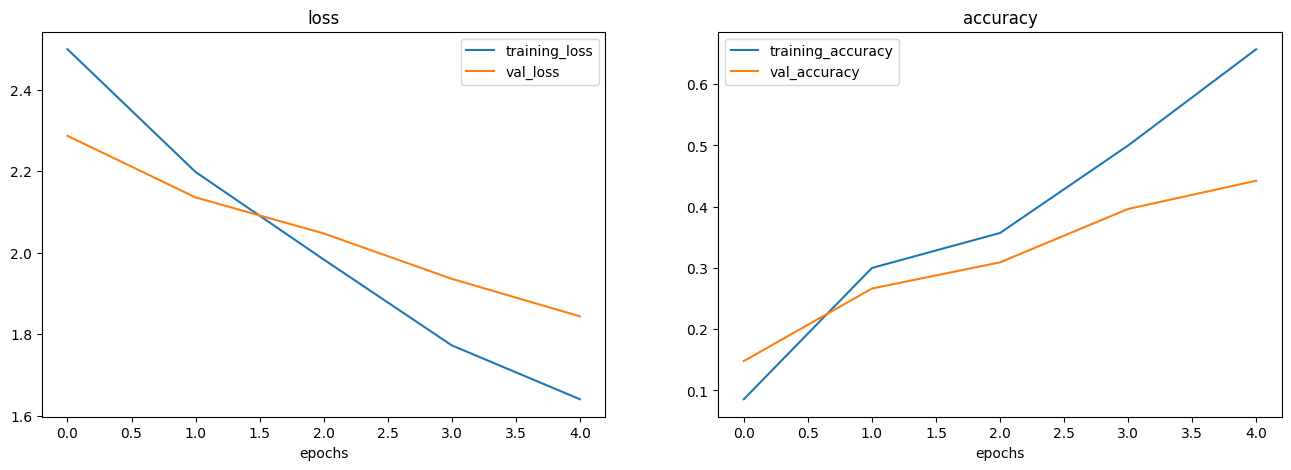

In [25]:
# Check models data augmentation
plot_loss_curves(history_model_1)

In [26]:
# Check out the model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

## **Model_2: feature extraction transfer learning model with 10% of the data and data augmentation**

In [27]:
# Get 10% of data
unzip_data(filename='data/10_food_classes_10_percent.zip', dest='data')

train_dir_10_percent = 'data/10_food_classes_10_percent/train'
test_dir = 'data/10_food_classes_10_percent/test'

In [28]:
# How many images are in directories
walk_through_dir('data/10_food_classes_10_percent')

There are 2 directories and 0 images in "data/10_food_classes_10_percent".
There are 10 directories and 0 images in "data/10_food_classes_10_percent\test".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\chicken_curry".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\chicken_wings".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\fried_rice".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\grilled_salmon".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\hamburger".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\ice_cream".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\pizza".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\ramen".
There are 0 directories and 250 images in "data/10_food_classes_10_percent\test\steak".
There are 0 di

In [29]:
# Set data inputs
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_10_percent,
                                                                            label_mode='categorical',
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [30]:
# Create model 2 with data augmentation built in
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    # tf.keras.layers.experimental.preprocessing.Rescaling(1./255) # for EfficientNet model it's not needed
], name='data_augmentation')

# Setup the input shape to the model
input_shape = (224, 224, 3)

# Create a frozen base model (also calld the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs) # augment the training data
x = base_model(x, training=False) # pass the augmented images to the base model, but keep it in inferenece mode - batchnorm layers are not updated
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_2D')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile a model
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### **Creating a ModelCheckpoint callback**

The **ModelCheckpoint** callback intermediately saves our model (the full model of just the weights) during training. This is useful so we can come and start where we letf off.

In [31]:
# Set checkpoint path
checkpoint_path = 'ten_percent_model_checkpoints/checkpoint.ckpt'

# Creata a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch',
                                                         verbose=1) # save every epoch

### **Fit model_2**

In [32]:
# Fit the model saving checkpoings every epoch
initial_epochs = 5

history_model_2 = model_2.fit(train_data_10_percent,
                              epochs=initial_epochs,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)),
                              callbacks=[checkpoint_callback,
                                         create_tensorboad_callback(dir_name='transfer_learning', 
                                                                    experiment_name='10_percent_data_aug')])

Saving TensorBoad log files to transfer_learning/10_percent_data_aug/2022-11-01_19-06-32
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.4408 - accuracy: 0.2000
Epoch 1: saving model to ten_percent_model_checkpoints\checkpoint.ckpt
24/24 [==============================] - 78s 3s/step - loss: 0.4408 - accuracy: 0.2000 - val_loss: 0.3005 - val_accuracy: 0.4227
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.5693
Epoch 2: saving model to ten_percent_model_checkpoints\checkpoint.ckpt
24/24 [==============================] - 55s 2s/step - loss: 0.2754 - accuracy: 0.5693 - val_loss: 0.2376 - val_accuracy: 0.7270
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.2331 - accuracy: 0.7040
Epoch 3: saving model to ten_percent_model_checkpoints\checkpoint.ckpt
24/24 [==============================] - 55s 2s/step - loss: 0.2331 - accuracy: 0.7040 - val_loss: 0.2034 - val_accuracy: 0.7829
Epoch 4/5
24/24 [===============

In [33]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 128s 2s/step - loss: 0.5523 - accuracy: 0.8648


[0.5523282885551453, 0.864799976348877]

In [34]:
# Check model_2 results on all data
results_10_percent_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 124s 2s/step - loss: 0.1675 - accuracy: 0.8212


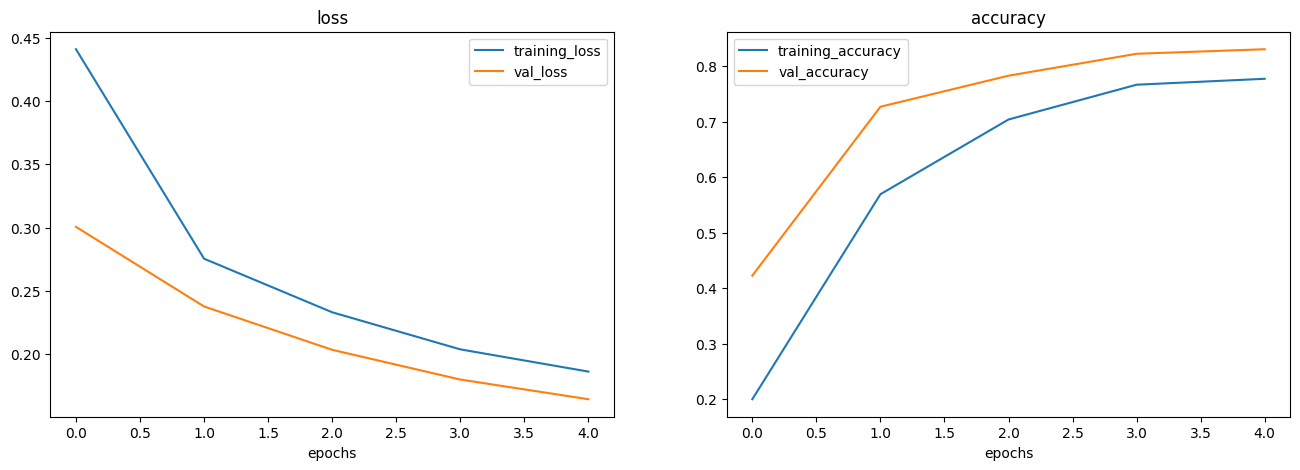

In [35]:
# Plot loss curves
plot_loss_curves(history_model_2)

### **Loading in checkpointed weights**

Loading in checkpointed weights returns a model to a specific checkpoint.

In [36]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [37]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 116s 1s/step - loss: 0.1675 - accuracy: 0.8212


In [38]:
# If the results from previously evaluated model_2 match the loaded weights, everuthing has worked
print(f'Are they equal: {results_10_percent_data_aug == loaded_weights_model_results}')
results_10_percent_data_aug, loaded_weights_model_results

Are they equal: False


([0.16752883791923523, 0.8212000131607056],
 [0.16752879321575165, 0.8212000131607056])

In [39]:
# Check to see if loaded model results are very close to previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])